In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import skimage
#%matplotlib qt

In [2]:
nxy = [[9,5],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[9,6],[8,6],[7,6],[9,6],[9,6],[9,6],[9,6]]

print((nxy[0][1]))

5


In [ ]:
img_files = os.listdir('./camera_cal/')

test_images = np.zeros((1,720,1280), dtype=np.int8)

plt.figure(figsize=(16, 25))

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

i = 1;
index = 0;
for i_file in img_files:
    #print(i_file)
    image = './camera_cal/' + i_file
    img = plt.imread(image)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = skimage.img_as_ubyte(gray, force_copy=True)
    
    #print(img.shape)
    #print(test_images.shape)
    img = cv2.resize(img, (1280,720))
    #print(img.shape)
    plt.subplot(20, 2, i)  # 1 rows x 5 columns
    #print(label)
    plt.title( "{0}:  {1}".format(
                str(i_file), img.shape))
    i += 1
    plt.axis("off")
    plt.imshow(img, cmap='gray')
    #print(img)
    #if(img.shape[2]==3):
#    test_images = np.append(test_images, [img[:,:]], axis=0)
    #else:
    #    print(i_file)
    #    im = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    #    plt.imshow(img)
    #    print(im.shape)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx = nxy[index][0]
    ny = nxy[index][1]
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Find the chessboard corners
    
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)
        plt.subplot(20, 2, i)  # 1 rows x 5 columns
        #print(label)
        plt.title( "{0}:  {1}".format(
                    str(i_file), img.shape))

        plt.axis("off")
        plt.imshow(img, cmap='gray')
    else:
        #plt.imshow()
        plt.subplot(20, 2, i)
        print("None!")
    i += 1
    
    index += 1
    
plt.show()

# Remove the zero matrix at index 0
#test_images = test_images[1:]

In [ ]:
print(objpoints)
print(imgpoints)

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
        #cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img_org.shape, dtype=np.uint8)
    #line_img = np.copy(img)*0 # creating a blank to draw lines on
    height = img.shape[0]
    line_img = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)
    lines_more = []
    if lines!= None:
        l = 0
        r = 0
        for line in lines:
            x1=line[0][0]
            y1=line[0][1]
            x2=line[0][2]
            y2=line[0][3]
            k = float(y2-y1)/(x2-x1)
            #print(k)
            if( (k>0.45 and k<0.65) or (k>-0.9 and k<-0.6) ):
                #lines_more.append(line)
                '''for x1,y1,x2,y2 in line:
                k = float(y2-y1)/(x2-x1)'''
                #extend to bottom
                if y1 > y2:
                    x1 = int(x2 + (height-y2)/k)
                    y1 = height
                    x2 = int(x1 - (height-460)/k)
                    y2 = 460
                elif y1 < y2:
                    x2 = int(x1 + (height-y1)/k)
                    y2 = height 
                    x1 = int(x2 - (height-460)/k)
                    y1 = 460 
                #lines_more.append([[x1,y1,x2,y2]])
                if k > 0:
                    if l == 0:
                        lines_more.append([[x1,y1,x2,y2]])
                        l = len(lines_more)
                    else:                        
                        lines_more[(l-1)][0][0] = (int)((lines_more[l-1][0][0]+x1)/2)
                        lines_more[(l-1)][0][1] = (int)((lines_more[l-1][0][1]+y1)/2)
                        lines_more[(l-1)][0][2] = (int)((lines_more[l-1][0][2]+x2)/2)
                        lines_more[(l-1)][0][3] = (int)((lines_more[l-1][0][3]+y2)/2)
                else:
                    if r == 0:
                        lines_more.append([[x1,y1,x2,y2]])
                        r = len(lines_more)
                    else:
                        lines_more[(r-1)][0][0] = (int)((lines_more[r-1][0][0]+x1)/2)
                        lines_more[(r-1)][0][1] = (int)((lines_more[r-1][0][1]+y1)/2)
                        lines_more[(r-1)][0][2] = (int)((lines_more[r-1][0][2]+x2)/2)
                        lines_more[(r-1)][0][3] = (int)((lines_more[r-1][0][3]+y2)/2)          

    draw_lines(line_img, lines_more)
    #draw_lines(line_img, lines)
    return line_img, lines_more

In [5]:
def sliding_window(org_img, start_p, size_n):
    #print(org_img.shape)
    h, w = org_img.shape
    x, y = start_p[0], start_p[1]
    s_x = int(max(0, x-size_n/2))
    s_y = max(0, y-size_n)
    s_w = size_n
    if((x+size_n/2)>w):
        s_w = x+size_n-w
    elif(x<(size_n/2)):
        s_w = x+size_n/2
    s_h = size_n
    if((y<size_n)):
        s_h = y
    #print(s_y,s_h, s_x,s_w)
    pis_img = org_img[s_y:s_y+s_h, s_x:s_x+s_w]#[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    #print(pis_img.shape)
    return pis_img, (s_x, s_w+s_x, s_y, s_h+s_y)
    

In [123]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, os

import matplotlib.gridspec as gridspec


test_images = np.zeros((1,720,1280), dtype=np.int8)

img_size = (1280, 720)
# Do camera calibration given object points and image points

''' to be put back. '''
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

ksize = 3

i = 1;
index = 0;

def process_gray_hls(img, data):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    #print("s_channel", s_channel.shape)

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray, s_channel

def process_sobel_s(gray, data):
    #img = data[0]
    #gray = data[0]
    s_channel = data
    #print("schannel: " ,s_channel.shape)
    #print(s_channel)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #print(sxbinary.shape)
    #print(s_binary.shape)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, 0
    
def process_ior_hough(combined_binary, data):
    triangle = np.array([[550,440],[770,440],[1180,720],[100,720]], np.int32)
    ior_img = region_of_interest(combined_binary, [triangle])

    ior_img[ior_img==1]=255
    hough_img, lines = hough_lines(ior_img, 1, np.radians(1), 80, 120, 90)
    
    return ior_img, lines
    
def process_perspective(ior_img, data):
    #ior_img = data[0]
    lines = data
    
    # Choose an offset from image corners to plot detected corners
    offset = 100 # offset for dst points

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([(lines[0][0][2], lines[0][0][3]), (lines[1][0][0], lines[1][0][1]), 
                      (lines[1][0][2], lines[1][0][3]), (lines[0][0][0], lines[0][0][1])])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                     [img_size[0]-offset, img_size[1]-10], 
                     [offset, img_size[1]-10]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(ior_img, M, img_size)
    # Return the resulting image and matrix
    return warped, M
    
def process_lanes(warped, data):
    M = data
    warped_result = np.copy(warped)
    
    calc_curvature = cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB)
    #calc_curvature1 = np.copy(calc_curvature)
    
    #720,1280
    warped = cv2.resize(warped, (256,144)) # to 1/5 of size
    warped[warped<100] = 0
    warped[warped>=100] = 1
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    #print(histogram)
    
    his_copy = np.copy(histogram)
    
    bin_max = np.where(his_copy == his_copy.max())
    start_p1 = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
    #print(start_p1)
    
    bounds = (max(0, start_p1-30), min(len(his_copy)-1, start_p1+30))
    his_copy[bounds[0]:bounds[1] + 1] = [0] * ((bounds[1] + 1) - bounds[0])
    #print(start_p1, bounds)
    #print(bin_max)
    
    bin_max = np.where(his_copy == his_copy.max())
    start_p2 = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
    #print(start_p1)
    #print(start_p1, bounds)
    #print(bin_max)
    
    subarea_edge_h = 36
    subarea_edge_w = subarea_edge_h #64
    
            # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    #sub_list =[]
    next_pos = start_p1
    for s_i in range (int(144/subarea_edge_h)):  
        #print("input pos:", next_pos)
        sub10, sub_area = sliding_window(warped, (next_pos, 144-s_i*subarea_edge_h), subarea_edge_h)
        #sub_list.append(sub10)
        start_p1 = next_pos
        sub_hist = np.sum(sub10[sub10.shape[0]/2:,:], axis=0)
        #print(start_p1)
        bin_max = np.where(sub_hist == sub_hist.max())
        #print(bin_max)
        next_pos = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
        next_pos = start_p1 + next_pos - subarea_edge_w/2
        next_pos = max(0, next_pos)
        #print("output pos:", next_pos)
        
        #print("positions: ", sub_area) #calc_curvature
        y1 = sub_area[2]*5
        y2 = sub_area[3]*5
        x1 = sub_area[0]*5
        x2 = sub_area[1]*5
        calc_curvature[y1:y2,x1:x2,0] = 0
        calc_curvature[y1:y2,x1:x2,1] = 0
        
    left = np.copy(calc_curvature[:,:,2])
    left = left - calc_curvature[:,:,0]
    
    yvals_left = []
    leftx = []
    #print(left.shape)
    for row in range(left.shape[0]):
        for col in range(left.shape[1]):
            if left[row][col] != 0:
                yvals_left.append(row)
                leftx.append(col)
    
    #print("len: ", len(yvals_left), len(leftx) )
    #print("maxmin:", max(yvals_left), min(yvals_left))
    #print("maxmin:", max(leftx), min(leftx))
    
    yvals_left = np.array(yvals_left)
    leftx = np.array(leftx)
    left_fit = np.polyfit(yvals_left, leftx, 2)
    left_fitx = left_fit[0]*yvals_left**2 + left_fit[1]*yvals_left + left_fit[2]
    
    y_eval_left = np.max(yvals_left)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) \
    #                         /np.absolute(2*left_fit[0])



    left_fit_cr = np.polyfit(yvals_left*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
    #                            /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')


        
    sub_list =[]
    next_pos = start_p2
    for s_i in range (int(144/subarea_edge_h)):  
        #print("input pos:", next_pos)
        sub10, sub_area = sliding_window(warped, (next_pos, 144-s_i*subarea_edge_h), subarea_edge_h)
        sub_list.append(sub10)
        start_p1 = next_pos
        sub_hist = np.sum(sub10[sub10.shape[0]/2:,:], axis=0)
        #print(start_p1)
        bin_max = np.where(sub_hist == sub_hist.max())
        #print(bin_max)
        next_pos = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
        next_pos = start_p1 + next_pos - subarea_edge_w/2
        next_pos = max(0, next_pos)
        #print("output pos:", next_pos)
        
        #print("positions: ", sub_area) #calc_curvature
        y1 = sub_area[2]*5
        y2 = sub_area[3]*5
        x1 = sub_area[0]*5
        x2 = sub_area[1]*5
        calc_curvature[y1:y2,x1:x2,1] = 0
        calc_curvature[y1:y2,x1:x2,2] = 0     
        
    right = np.copy(calc_curvature[:,:,0])
    right = right - calc_curvature[:,:,1]
    
    yvals_right = []
    rightx = []
    #print(right.shape)
    for row in range(right.shape[0]):
        for col in range(right.shape[1]):
            if right[row][col] != 0:
                yvals_right.append(row)
                rightx.append(col)
    
    #print("len: ", len(yvals_right), len(rightx) )
    #print("maxmin:", max(yvals_right), min(yvals_right))
    #print("maxmin:", max(rightx), min(rightx))
    
    yvals_right = np.array(yvals_right)
    rightx = np.array(rightx)
    
    right_fit = np.polyfit(yvals_right, rightx, 2)
    right_fitx = right_fit[0]*yvals_right**2 + right_fit[1]*yvals_right + right_fit[2]

    y_eval_right = np.max(yvals_right)
    #right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) \
    #                            /np.absolute(2*right_fit[0])
    
    right_fit_cr = np.polyfit(yvals_right*ym_per_pix, rightx*xm_per_pix, 2)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
        
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals_left]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals_right])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result, 0
    

In [124]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def run_pipeline(initial_img, fns, fns_args):
    imgs = [initial_img]
    datas = [0]
    
    for fn, fn_args in zip(fns, fns_args):
#        print(fn)
#        print(datas[-1])
        img, data = fn(imgs[-1], datas[-1], *fn_args)
        imgs.append(img)
#        if(data == None ):
#            print("None")
        datas.append(data)
#        else:
#            print("Add one")
#            datas.append(data)
            #print(data.shape)
#            print(data)
        
    return imgs

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    '''functs = (grayscale, gaussian_blur, canny, region_of_interest, hough_lines, weighted_img)
    functs_args = (
        (), 
        (5,),
        (50, 150),
        (np.array([[(120,530),(440, 320), (520, 320), (910,530)]], dtype=np.int32),), 
        (1, np.radians(1), 50, 100, 120),
        (np.copy(image),)
    )'''
    functs = (process_gray_hls, process_sobel_s, process_ior_hough, process_perspective, process_lanes )
    functs_args = ((), (), (), (), ())
    imgs = run_pipeline(image, functs, functs_args)
    result = imgs[-1]

    return result

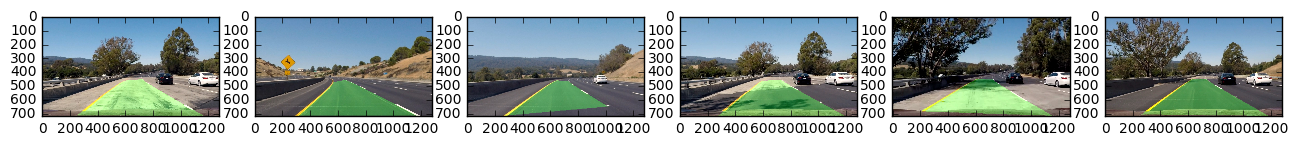

In [126]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, os

import matplotlib.gridspec as gridspec

img_files = os.listdir('./test_images/')

plt.close('all')

plt.figure(figsize=(16, 25))

i = 1;
for i_file in img_files:

    image = './test_images/' + i_file
    img = plt.imread(image)
    
    result = process_image(img)
    plt.subplot(1, 6, i)
    i += 1
    plt.imshow(result)
    
plt.show()

In [125]:
#imageio.plugins.ffmpeg.download()

white_output = 'result_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4










  0%|          | 0/1261 [00:00<?, ?it/s]







  0%|          | 1/1261 [00:03<1:10:41,  3.37s/it]







  0%|          | 2/1261 [00:06<1:10:59,  3.38s/it]

TypeError: expected non-empty vector for x

## Jim, please see below

In [ ]:
# Run this cell to watch the video processing frame by frame in an OpenCV window 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
#%matplotlib qt

# Unpack camera calibration data
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define initial region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)
new_dict = {'vertices':vertices}

# Create some new Line objects
left_line = Line()
right_line = Line()

# Start up OpenCV window
cv2.startWindowThread()
cv2.namedWindow('Lane-Finding')
cv2.moveWindow('Lane-Finding', 0, 0)

# Change this based on your code directory
cap = cv2.VideoCapture('../project_video.mp4')

while cap.isOpened():

    ret, image = cap.read()
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output = process_image(image)
        reout = cv2.resize(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), (640, 360))
        cv2.imshow('Lane-Finding', reout)    
    else:
        break      
    k = cv2.waitKey(30) & 0xff
    if k == 27 :
        break
cap.release()
cv2.destroyAllWindows()

## Call moviepy to process the entire video and output to file. The output file will be out_test.mp4 for the result.

In [ ]:
# Run this cell to process an entire video with moviepy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Unpack camera calibration data 
# You may want to rename this based on your pickle file you saved calibration
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Define initial region of interest
vertices = np.array([[(110,719), (625, 430), (680, 430), (1260, 719)]], dtype=np.int32)
new_dict = {'vertices':vertices}

# Create some new Line objects
left_line = Line()
right_line = Line()

test_output = 'out_test.mp4'
# Based on the code directory 
clip = VideoFileClip("../project_video.mp4")
test_clip = clip.fl_image(process_image)
#%time 
test_clip.write_videofile(test_output, audio=False)

## Display the result

In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
"""     testing functions below ...."""

In [20]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, os

import matplotlib.gridspec as gridspec

img_files = os.listdir('./test_images/')

test_images = np.zeros((1,720,1280), dtype=np.int8)

#plt.figure(figsize=(16, 25))

img_size = (1280, 720)
# Do camera calibration given object points and image points

''' to be put back. '''
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

plt.close('all')

ksize = 3

i = 1;
index = 0;
for i_file in img_files:
    #print(i_file)
    image = './test_images/' + i_file
    img = plt.imread(image)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    


    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    triangle = np.array([[550,440],[770,440],[1180,720],[100,720]], np.int32)
    ior_img = region_of_interest(combined_binary, [triangle])
    
    
    ior_img[ior_img==1]=255
    hough_img, lines = hough_lines(ior_img, 1, np.radians(1), 80, 120, 90)
    
    
    # Choose an offset from image corners to plot detected corners
    offset = 100 # offset for dst points

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([(lines[0][0][2], lines[0][0][3]), (lines[1][0][0], lines[1][0][1]), 
                      (lines[1][0][2], lines[1][0][3]), (lines[0][0][0], lines[0][0][1])])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                     [img_size[0]-offset, img_size[1]-10], 
                     [offset, img_size[1]-10]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(ior_img, M, img_size)
    # Return the resulting image and matrix
    
    warped_result = np.copy(warped)
    
    calc_curvature = cv2.cvtColor(warped,cv2.COLOR_GRAY2RGB)
    #calc_curvature1 = np.copy(calc_curvature)
    
    #720,1280
    warped = cv2.resize(warped, (256,144)) # to 1/5 of size
    warped[warped<100] = 0
    warped[warped>=100] = 1
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    #print(histogram)
    
    his_copy = np.copy(histogram)
    
    bin_max = np.where(his_copy == his_copy.max())
    start_p1 = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
    #print(start_p1)
    
    bounds = (max(0, start_p1-30), min(len(his_copy)-1, start_p1+30))
    his_copy[bounds[0]:bounds[1] + 1] = [0] * ((bounds[1] + 1) - bounds[0])
    #print(start_p1, bounds)
    #print(bin_max)
    
    bin_max = np.where(his_copy == his_copy.max())
    start_p2 = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
    #print(start_p1)
    #print(start_p1, bounds)
    #print(bin_max)
    
    subarea_edge_h = 36
    subarea_edge_w = subarea_edge_h #64
    
            # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    #sub_list =[]
    next_pos = start_p1
    for s_i in range (int(144/subarea_edge_h)):  
        print("input pos:", next_pos)
        sub10, sub_area = sliding_window(warped, (next_pos, 144-s_i*subarea_edge_h), subarea_edge_h)
        #sub_list.append(sub10)
        start_p1 = next_pos
        sub_hist = np.sum(sub10[sub10.shape[0]/2:,:], axis=0)
        #print(start_p1)
        bin_max = np.where(sub_hist == sub_hist.max())
        #print(bin_max)
        next_pos = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
        next_pos = start_p1 + next_pos - subarea_edge_w/2
        next_pos = max(0, next_pos)
        print("output pos:", next_pos)
        
        print("positions: ", sub_area) #calc_curvature
        y1 = sub_area[2]*5
        y2 = sub_area[3]*5
        x1 = sub_area[0]*5
        x2 = sub_area[1]*5
        calc_curvature[y1:y2,x1:x2,0] = 0
        calc_curvature[y1:y2,x1:x2,1] = 0
        
    left = np.copy(calc_curvature[:,:,2])
    left = left - calc_curvature[:,:,0]
    
    yvals_left = []
    leftx = []
    print(left.shape)
    for row in range(left.shape[0]):
        for col in range(left.shape[1]):
            if left[row][col] != 0:
                yvals_left.append(row)
                leftx.append(col)
    
    print("len: ", len(yvals_left), len(leftx) )
    print("maxmin:", max(yvals_left), min(yvals_left))
    print("maxmin:", max(leftx), min(leftx))
    
    yvals_left = np.array(yvals_left)
    leftx = np.array(leftx)
    left_fit = np.polyfit(yvals_left, leftx, 2)
    left_fitx = left_fit[0]*yvals_left**2 + left_fit[1]*yvals_left + left_fit[2]
    
    y_eval_left = np.max(yvals_left)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) \
    #                         /np.absolute(2*left_fit[0])



    left_fit_cr = np.polyfit(yvals_left*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
    #                            /np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')


        
    sub_list =[]
    next_pos = start_p2
    for s_i in range (int(144/subarea_edge_h)):  
        print("input pos:", next_pos)
        sub10, sub_area = sliding_window(warped, (next_pos, 144-s_i*subarea_edge_h), subarea_edge_h)
        sub_list.append(sub10)
        start_p1 = next_pos
        sub_hist = np.sum(sub10[sub10.shape[0]/2:,:], axis=0)
        #print(start_p1)
        bin_max = np.where(sub_hist == sub_hist.max())
        #print(bin_max)
        next_pos = int(( bin_max[0][0] + bin_max[0][len(bin_max[0])-1] )/2)
        next_pos = start_p1 + next_pos - subarea_edge_w/2
        next_pos = max(0, next_pos)
        print("output pos:", next_pos)
        
        print("positions: ", sub_area) #calc_curvature
        y1 = sub_area[2]*5
        y2 = sub_area[3]*5
        x1 = sub_area[0]*5
        x2 = sub_area[1]*5
        calc_curvature[y1:y2,x1:x2,1] = 0
        calc_curvature[y1:y2,x1:x2,2] = 0     
        
    right = np.copy(calc_curvature[:,:,0])
    right = right - calc_curvature[:,:,1]
    
    yvals_right = []
    rightx = []
    print(right.shape)
    for row in range(right.shape[0]):
        for col in range(right.shape[1]):
            if right[row][col] != 0:
                yvals_right.append(row)
                rightx.append(col)
    
    print("len: ", len(yvals_right), len(rightx) )
    print("maxmin:", max(yvals_right), min(yvals_right))
    print("maxmin:", max(rightx), min(rightx))
    
    yvals_right = np.array(yvals_right)
    rightx = np.array(rightx)
    
    right_fit = np.polyfit(yvals_right, rightx, 2)
    right_fitx = right_fit[0]*yvals_right**2 + right_fit[1]*yvals_right + right_fit[2]

    #y_eval_right = np.max(yvals_right)
    #right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) \
    #                            /np.absolute(2*right_fit[0])
    
    right_fit_cr = np.polyfit(yvals_right*ym_per_pix, rightx*xm_per_pix, 2)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
        
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_result).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals_left]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals_right])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)


    print("done an image................")
    
    #calc_curvature
    
    
    
    # Plotting thresholded images
    '''
    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(1, 10, figsize=(20,10)) #, 
    f.tight_layout()
    '''
    fig = plt.figure(figsize=(16, 8)) 

    gs = gridspec.GridSpec(3, 5)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[0, 2])
    ax4 = plt.subplot(gs[0, 3])
    ax5 = plt.subplot(gs[0, 4])
    
    ax6 = plt.subplot(gs[1,0])
    ax7 = plt.subplot(gs[1,1])
    ax8 = plt.subplot(gs[1,2])
    ax9 = plt.subplot(gs[1,3])
    ax10 = plt.subplot(gs[1,4])
    
    ax11 = plt.subplot(gs[2,0])
    ax12 = plt.subplot(gs[2,1])
    
    ax13 = plt.subplot(gs[2,2])
    ax14 = plt.subplot(gs[2,3])
    
    ax15 = plt.subplot(gs[2,4])
    


    ax1.set_title('Stacked thresholds')
    ax1.imshow(img)
    #print(img.shape)
    
    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    #print(combined_binary.shape)
    
    ax3.set_title('Interest of Region')
    ax3.imshow(ior_img, cmap='gray')
    
    ax4.set_title('Hough')
    ax4.imshow(hough_img, cmap='gray')
    
    ax5.set_title('Perspective')
    ax5.imshow(warped, cmap='gray')
    
    ax6.set_title('Sub1 img')
    ax6.imshow(sub_list[0], cmap='gray')
    
    ax7.set_title('Sub2 img')
    ax7.imshow(sub_list[1], cmap='gray')
    
    ax8.set_title('Sub3 img')
    ax8.imshow(sub_list[2], cmap='gray')
    
    ax9.set_title('Sub4 img')
    ax9.imshow(sub_list[3], cmap='gray')
    
    ax10.set_title('lines')
    ax10.imshow(calc_curvature)
    
    ax11.set_title('left')
    ax11.imshow(left, cmap='gray')
    
    ax12.set_title('right')
    ax12.imshow(right, cmap='gray')
    
    ax13.plot(leftx, yvals_left, 'o', color='green')
    ax13.set_xlim([0, 1280])
    ax13.set_ylim([0, 720])
    ax13.plot(left_fitx, yvals_left, color='blue', linewidth=3)
    ax13.invert_yaxis()
    
    ax14.plot(rightx, yvals_right, 'o', color='green')
    ax14.set_xlim([0, 1280])
    ax14.set_ylim([0, 720])
    ax14.plot(right_fitx, yvals_right, color='red', linewidth=3)
    ax14.invert_yaxis()
    
    ax15.set_title('Result')
    ax15.imshow(result)
    
    '''
    ax11.set_title('Sub3 img')
    ax11.imshow(sub_list[5], cmap='gray')
    '''
    #ax6.plot(hist)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    plt.show()


input pos: 23
output pos: 21.0
positions:  (5, 41, 108, 144)
input pos: 21.0
output pos: 22.0
positions:  (3, 39, 72, 108)
input pos: 22.0
output pos: 30.0
positions:  (4, 40, 36, 72)
input pos: 30.0
output pos: 39.0
positions:  (12, 48, 0, 36)
(720, 1280)
len:  19511 19511
maxmin: 708 170
maxmin: 206 25
input pos: 237
output pos: 234.0
positions:  (219, 255, 108, 144)
input pos: 234.0
output pos: 236.0
positions:  (216, 252, 72, 108)
input pos: 236.0
output pos: 238.0
positions:  (218, 254, 36, 72)
input pos: 238.0
output pos: 246.0
positions:  (220, 256, 0, 36)
(720, 1280)
len:  16090 16090
maxmin: 709 0
maxmin: 1279 1095


NameError: name 'y_eval_right' is not defined

[   0.     7.2   14.4   21.6   28.8   36.    43.2   50.4   57.6   64.8
   72.    79.2   86.4   93.6  100.8  108.   115.2  122.4  129.6  136.8
  144.   151.2  158.4  165.6  172.8  180.   187.2  194.4  201.6  208.8
  216.   223.2  230.4  237.6  244.8  252.   259.2  266.4  273.6  280.8
  288.   295.2  302.4  309.6  316.8  324.   331.2  338.4  345.6  352.8
  360.   367.2  374.4  381.6  388.8  396.   403.2  410.4  417.6  424.8
  432.   439.2  446.4  453.6  460.8  468.   475.2  482.4  489.6  496.8
  504.   511.2  518.4  525.6  532.8  540.   547.2  554.4  561.6  568.8
  576.   583.2  590.4  597.6  604.8  612.   619.2  626.4  633.6  640.8
  648.   655.2  662.4  669.6  676.8  684.   691.2  698.4  705.6  712.8
  720. ]
(101,)
[ 432.36      421.233536  436.148544  386.105024  399.102976  384.1424
  406.223296  418.345664  382.509504  330.714816  386.9616    397.249856
  327.579584  365.950784  327.363456  393.8176    301.313216  344.850304
  385.428864  326.048896  296.7104    313.413376  294.157

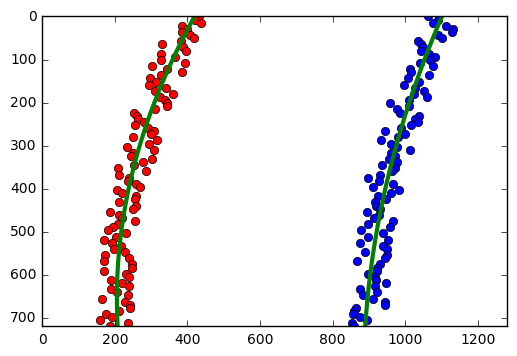

In [51]:
#def plot_twolanes(lanes_image_left, lanes_image_right):
    
# Generate some fake data to represent lane-line pixels
yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
leftx = np.array([200 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                              for idx, elem in enumerate(yvals)])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = np.array([900 + (elem**2)*4e-4 + np.random.randint(-50, high=51) 
                                for idx, elem in enumerate(yvals)])
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

print(yvals)
print(yvals.shape)
print(leftx)
print(leftx.shape)

# Fit a second order polynomial to each fake lane line
left_fit = np.polyfit(yvals, leftx, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fit = np.polyfit(yvals, rightx, 2)
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

# Plot up the fake data
plt.plot(leftx, yvals, 'o', color='red')
plt.plot(rightx, yvals, 'o', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.plot(right_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(yvals)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) \
                             /np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) \
                                /np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1163.9    1213.7

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                /np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 3380.7 m    3189.3 m

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [28]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)


    #undist = np.copy(img)  # Delete this line
    return undist

In [ ]:
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose an offset from image corners to plot detected corners
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                         [img_size[0]-offset, img_size[1]-offset], 
                         [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        # Return the resulting image and matrix
        return warped, M
    return None,None

In [ ]:
img_files = os.listdir('./camera_cal/')

test_images = np.zeros((1,720,1280), dtype=np.int8)

plt.figure(figsize=(16, 25))

i = 1;

for i_file in img_files:
    #print(i_file)
    image = './camera_cal/' + i_file
    img = plt.imread(image)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #print(img.shape)
    #print(test_images.shape)
    img = cv2.resize(img, (1280,720))
    #print(img.shape)
    plt.subplot(5, 5, i)  # 1 rows x 5 columns
    #print(label)
    plt.title( "{0}:  {1}".format(
                str(i_file), img.shape))
    i += 1
    plt.imshow(img, cmap='gray')
    #print(img)
    #if(img.shape[2]==3):
    test_images = np.append(test_images, [img[:,:]], axis=0)
    #else:
    #    print(i_file)
    #    im = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    #    plt.imshow(img)
    #    print(im.shape)

plt.show()

# Remove the zero matrix at index 0
test_images = test_images[1:]


In [ ]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [ ]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [ ]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
img_files = os.listdir('./test_images/')

test_images = np.zeros((1,720,1280), dtype=np.int8)

plt.figure(figsize=(16, 25))

img_size = (1280, 720)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
plt.figure(figsize=(16, 25))

ksize = 3

i = 1;
index = 0;
for i_file in img_files:
    #print(i_file)
    image = './test_images/' + i_file
    img = plt.imread(image)
    #print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = skimage.img_as_ubyte(gray, force_copy=True)
    
    plt.subplot(20, 7, i)  
    plt.title( "{0}:  {1}".format(
                str(i_file), img.shape))
    i += 1
    plt.axis("off")
    plt.imshow(gray, cmap='gray')

    undist = cv2.undistort(gray, mtx, dist, None, mtx)
    plt.subplot(20, 7, i)  
    plt.title( "undistort")
    i += 1
    plt.axis("off")
    plt.imshow(undist, cmap='gray')
    
    grad_x = abs_sobel_thresh(undist, orient='x', thresh_min=20, thresh_max=100)
    plt.subplot(20, 7, i)  
    plt.title( "sobel_x")
    i += 1
    plt.axis("off")
    plt.imshow(grad_x, cmap='gray')
    
    grad_y = abs_sobel_thresh(undist, orient='y', thresh_min=20, thresh_max=100)
    plt.subplot(20, 7, i)  
    plt.title( "sobel_y")
    i += 1
    plt.axis("off")
    plt.imshow(grad_y, cmap='gray')
    
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30,100))
    plt.subplot(20, 7, i)  
    plt.title( "mag")
    i += 1
    plt.axis("off")
    plt.imshow(mag_binary, cmap='gray')
    
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.7,np.pi/2))
    plt.subplot(20, 7, i)  
    plt.title( "dir")
    i += 1
    plt.axis("off")
    plt.imshow(dir_binary, cmap='gray')
    
    combined = np.zeros_like(dir_binary)
    combined[((grad_x==1)&(grad_y==1)) | ((mag_binary==1)&(dir_binary==1))] = 1
    plt.subplot(20, 7, i)  
    plt.title( "com")
    i += 1
    plt.axis("off")
    plt.imshow(combined, cmap='gray')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test6.jpg') 

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Isolate a singular color channel:
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    #Create a binary threshold on a specific color channel (S in this case):
    
    retval, s_binary = cv2.threshold(s.astype('uint8'), 90, 255, cv2.THRESH_BINARY)
    #binary_output = np.copy(img) # placeholder line
    return s_binary
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('bridge_shadow.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    retval, sxbinary = cv2.threshold(abssx, 15, 150, cv2.THRESH_BINARY)
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), 175, 255, cv2.THRESH_BINARY)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 7#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'camera_cal/calibration4.png'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
else:
    plt.imshow(img)

In [ ]:
# Test undistortion on an image
# Read in an image
#nx = 11 # the number of inside corners in x
#ny = 5 # the number of inside corners in y

img = cv2.imread('camera_cal/calibration4.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = skimage.img_as_ubyte(gray, force_copy=True)
print(gray.shape)

plt.imshow(gray)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


for nx in range(6,13):
    for ny in range(3,10):
        img_size = (gray.shape[1], gray.shape[0])
   #     print(img_size)
   #     print(gray.shape)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
            print(nx, ny)
        else:
            print(nx, ny, " None!")

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration5.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration2.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'calibration_test.png'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

In [ ]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_image2.png')
nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

#Try different combinations and see what you get. For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, or the gradient magnitude and direction are both within their threshold values.

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

In [ ]:
hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
Isolate a singular color channel:

h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]
Create a binary threshold on a specific color channel (S in this case):

retval, s_binary = cv2.threshold(s.astype('uint8'), 90, 255, cv2.THRESH_BINARY)